In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wrf
import netCDF4 as nc
import warnings
import pyart
import pandas as pd
import tqdm
import metpy.calc as mpcalc

warnings.simplefilter("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [2]:
def load_transect(tpath,t_fname,hpath,h_fname):

    #Load cross section
    ctrl = xr.open_dataset(tpath + t_fname)
    
    #Change theta pert. Define as the perturbation in theta relative to the transect at each height.
    ctrl["theta_pert"] = ctrl["theta"] - ctrl.theta.sel(cross_line_idx=slice(25,50)).mean(("cross_line_idx","transect"))
    
    #Define cold pool depth, H, as when the mean cold pool theta perturbation goes above -1 K
    thresh=-1
    cond = (ctrl.sel(cross_line_idx=slice(0,25),vertical=slice(0,3000)).theta_pert).mean("cross_line_idx") <= thresh
    heights = np.repeat(ctrl.sel(vertical=slice(0,3000)).vertical.values[np.newaxis],cond.transect.shape[0],axis=0)
    H = np.nanmax(np.where(cond,heights,np.nan),axis=1)
    ctrl["H"] = (["transect"],H)
    
    #Ambient wind, U0, defined as the mean line-perpendicular wind speed ahead of the cold pool over H
    U0 = [ctrl["along_transect_wind"].sel(cross_line_idx=slice(25,50),vertical=slice(0,h),transect=t).mean(("cross_line_idx","vertical"))\
          for t, h in zip(range(ctrl.transect.shape[0]), H)]
    ctrl["U0"] = (["transect"],U0)    
    
    #Cold pool speed, Uc, defined as the maximum surace wind speed in the cold pool
    ctrl["Uc"] = ctrl["along_transect_wind"].sel(cross_line_idx=slice(0,25)).isel(vertical=0).max(("cross_line_idx"))
    
    return ctrl.assign_coords({"transect":ctrl.transect})

    
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)    
    
    

In [3]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/"

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:30:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00"]
ctrl_list = []

for t, h in tqdm.tqdm(zip(t_fname,h_fname)):
    ctrl = load_transect(tpath,t,hpath,h)
    ctrl_list.append(ctrl)
    
for i in range(1,len(ctrl_list)):
    ctrl_list[i] = ctrl_list[i].interp({"cross_line_idx":ctrl_list[0].cross_line_idx},method="linear")
    
ctrl_list = xr.concat(ctrl_list,"Time")    

3it [01:30, 30.25s/it]


In [4]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus/"

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_03:30:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00"]
plus_3K_list = []

for t, h in tqdm.tqdm(zip(t_fname,h_fname)):
    plus_3K = load_transect(tpath,t,hpath,h)
    plus_3K_list.append(plus_3K)
    
for i in range(1,len(plus_3K_list)):
    plus_3K_list[i] = plus_3K_list[i].interp({"cross_line_idx":plus_3K_list[0].cross_line_idx},method="linear")
    
plus_3K_list = xr.concat(plus_3K_list,"Time")    

3it [00:00, 10.62it/s]


In [5]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus/"

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_03:30:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00"]
minus_3K_list = []

for t, h in tqdm.tqdm(zip(t_fname,h_fname)):
    minus_3K = load_transect(tpath,t,hpath,h)
    minus_3K_list.append(minus_3K)
    
for i in range(1,len(minus_3K_list)):
    minus_3K_list[i] = minus_3K_list[i].interp({"cross_line_idx":minus_3K_list[0].cross_line_idx},method="linear")    
    
minus_3K_list = xr.concat(minus_3K_list,"Time")    

3it [00:00,  7.87it/s]


In [6]:
def theory(ls):
    rho1 = ls.rho.sel(cross_line_idx=slice(20,25)).isel(vertical=0).mean(("cross_line_idx"))
    rho2 = ls.rho.sel(cross_line_idx=slice(25,30)).isel(vertical=0).mean(("cross_line_idx"))

    k = 1
    b = 0.74
    g = 9.8

    density_speed = ((k * np.sqrt(g * ls.H * (rho1-rho2)/rho1)))
    ambient_speed =  b*ls["U0"]
    total_speed = density_speed + ambient_speed
    
    # print("H=",ls.H.mean(("transect","Time")).values.round(2),
    #       "\nRho diff=",((theta1-theta2)).mean(("transect","Time")).values.round(3),
    #      "\nRho 1=",(theta1).mean(("transect","Time")).values.round(3),
    #      "\nRho 2=",(theta2).mean(("transect","Time")).values.round(3),)
    
    return total_speed, density_speed, ambient_speed, rho1, rho1-rho2, ls.H

def find_speed(ctrl_list):
    
    system_lats = []
    system_lons = []
    speed = []
    for i, j in zip([0,1],[1,2]):
            for t in range(30):
                system_lat1 = ctrl_list.isel(Time=i).sel(transect=t,cross_line_idx=25,method="nearest").xy_lat.values
                system_lon1 = ctrl_list.isel(Time=i).sel(transect=t,cross_line_idx=25,method="nearest").xy_lon.values
                system_lat2 = ctrl_list.isel(Time=j).sel(transect=t,cross_line_idx=25,method="nearest").xy_lat.values
                system_lon2 = ctrl_list.isel(Time=j).sel(transect=t,cross_line_idx=25,method="nearest").xy_lon.values    
                delta_t = (ctrl_list.isel(Time=j).Time - ctrl_list.isel(Time=i).Time).values / np.timedelta64(1, 'h')
                speed.append((latlon_dist(system_lat1,system_lon1,system_lat2,system_lon2)/delta_t/3.6))
    print(np.median(speed), np.quantile(speed,0.25), np.quantile(speed,0.75))
    return np.median(speed)

In [7]:
find_speed(ctrl_list)

16.21217444589295 15.384665735763761 16.975013057318588


16.21217444589295

In [56]:
ls = ctrl_list
uc = []
ut = []
ut_density = []
ut_ambient = []
rho1_ls = []
rho2_ls = []
h_ls = []
index = ["All transects","Transects 1-15","Transects 16-30"]
for transect_slice in [slice(0,30),slice(0,14),slice(15,30)]:
    uc.append(ls.sel(transect=transect_slice).Uc.mean())
    total_speed, density_speed, ambient_speed, rho1, rho2, H = theory(ls.sel(transect=transect_slice))
    ut.append(total_speed.mean().values)
    ut_density.append(density_speed.mean().values)
    ut_ambient.append(ambient_speed.mean().values) 
    rho1_ls.append(rho1.mean().values)
    rho2_ls.append(rho2.mean().values)    
    h_ls.append(H.mean().values)        

df = pd.DataFrame({"$U_c$ (m/s)":uc,
              "$U_t$ (m/s)":ut,
              "$C$ (m/s)":ut_density,
              "$bU_0$ (m/s)":ut_ambient,
              "$\rho_c$ (kg/m$^3$)":rho1_ls,
              "$\rho_c - \rho_w$ (kg/m$^3$)":rho2_ls,
              "$H$ (m)":h_ls},
            index=index).astype(float).round(decimals={"$U_c$ (m/s)":1,"$U_t$ (m/s)":1,"$C$ (m/s)":1,"$bU_0$ (m/s)":1,
                                                      "$\rho_c$ (kg/m$^3$)":3,"$\rho_c - \rho_w$ (kg/m$^3$)":3,"$H$ (m)":0})

df

,$U_c$ (m/s),$U_t$ (m/s),$C$ (m/s),$bU_0$ (m/s),$\rho_c$ (kg/m$^3$),$\rho_c - \rho_w$ (kg/m$^3$),$H$ (m)
All transects,16.3,16.5,9.9,6.6,1.211,0.012,1057.0
Transects 1-15,18.1,18.2,10.8,7.4,1.213,0.013,1142.0
Transects 16-30,14.6,14.9,9.0,5.9,1.210,0.010,973.0


In [57]:
df.to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n & $U_c$ (m/s) & $U_t$ (m/s) & $C$ (m/s) & $bU_0$ (m/s) & $\rho_c$ (kg/m$^3$) & $\rho_c - \rho_w$ (kg/m$^3$) & $H$ (m) \\\\\n\\midrule\nAll transects & 16.300000 & 16.500000 & 9.900000 & 6.600000 & 1.211000 & 0.012000 & 1057.000000 \\\\\nTransects 1-15 & 18.100000 & 18.200000 & 10.800000 & 7.400000 & 1.213000 & 0.013000 & 1142.000000 \\\\\nTransects 16-30 & 14.600000 & 14.900000 & 9.000000 & 5.900000 & 1.210000 & 0.010000 & 973.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [9]:
ls = ctrl_list
uc = []
ut = []
ut_density = []
ut_ambient = []
rho1_ls = []
rho2_ls = []
h_ls = []
index = ["WRF CTRL","WRF +3K","WRF -3K"]
transect_slice = slice(0,30)
for ls in [ctrl_list,plus_3K_list,minus_3K_list]:
    uc.append(ls.sel(transect=transect_slice).Uc.mean())
    total_speed, density_speed, ambient_speed, rho1, rho2, H = theory(ls.sel(transect=transect_slice))
    ut.append(total_speed.mean().values)
    ut_density.append(density_speed.mean().values)
    ut_ambient.append(ambient_speed.mean().values) 
    rho1_ls.append(rho1.mean().values)
    rho2_ls.append(rho2.mean().values)    
    h_ls.append(H.mean().values)        

df = pd.DataFrame({"$U_c$ (m/s)":uc,
              "$U_t$ (m/s)":ut,
              "$C$ (m/s)":ut_density,
              "$bU_0$ (m/s)":ut_ambient,
              "$\rho_c$ (kg/m$^3$)":rho1_ls,
              "$\rho_c - \rho_w$ (kg/m$^3$)":rho2_ls,
              "$H$ (m)":h_ls},
            index=index).astype(float).round(decimals={"$U_c$ (m/s)":1,"$U_t$ (m/s)":1,"$C$ (m/s)":1,"$bU_0$ (m/s)":1,
                                                      "$\rho_c$ (kg/m$^3$)":3,"$\rho_c - \rho_w$ (kg/m$^3$)":3,"$H$ (m)":0})
print(df.to_latex())
print(df)

\begin{tabular}{lrrrrrrr}
\toprule
ho_w$ (kg/m$^3$) & $H$ (m) \\& $C$ (m/s) & $bU_0$ (m/s) & $
\midrule
WRF CTRL & 16.300000 & 16.500000 & 9.900000 & 6.600000 & 1.211000 & 0.012000 & 1057.000000 \\
WRF +3K & 16.500000 & 16.700000 & 8.800000 & 7.900000 & 1.203000 & 0.009000 & 1110.000000 \\
WRF -3K & 12.200000 & 14.700000 & 8.100000 & 6.600000 & 1.217000 & 0.008000 & 1009.000000 \\
\bottomrule
\end{tabular}

          $U_c$ (m/s)  $U_t$ (m/s)  $C$ (m/s)  $bU_0$ (m/s)  \
WRF CTRL         16.3         16.5        9.9           6.6   
WRF +3K          16.5         16.7        8.8           7.9   
WRF -3K          12.2         14.7        8.1           6.6   

          $\rho_c$ (kg/m$^3$)  $\rho_c - \rho_w$ (kg/m$^3$)  $H$ (m)  
WRF CTRL                1.211                         0.012   1057.0  
WRF +3K                 1.203                         0.009   1110.0  
WRF -3K                 1.217                         0.008   1009.0  


In [58]:
ls = ctrl_list
uc = []
ut = []
ut_density = []
ut_ambient = []
rho1_ls = []
rho2_ls = []
h_ls = []
index = ["WRF CTRL","WRF +3K","WRF -3K"]
transect_slice = slice(0,14)
for ls in [ctrl_list,plus_3K_list,minus_3K_list]:
    uc.append(ls.sel(transect=transect_slice).Uc.mean())
    total_speed, density_speed, ambient_speed, rho1, rho2, H = theory(ls.sel(transect=transect_slice))
    ut.append(total_speed.mean().values)
    ut_density.append(density_speed.mean().values)
    ut_ambient.append(ambient_speed.mean().values) 
    rho1_ls.append(rho1.mean().values)
    rho2_ls.append(rho2.mean().values)    
    h_ls.append(H.mean().values)        

df = pd.DataFrame({"$U_c$ (m/s)":uc,
              "$U_t$ (m/s)":ut,
              "$C$ (m/s)":ut_density,
              "$bU_0$ (m/s)":ut_ambient,
              "$\rho_c$ (kg/m$^3$)":rho1_ls,
              "$\rho_c - \rho_w$ (kg/m$^3$)":rho2_ls,
              "$H$ (m)":h_ls},
            index=index).astype(float).round(decimals={"$U_c$ (m/s)":1,"$U_t$ (m/s)":1,"$C$ (m/s)":1,"$bU_0$ (m/s)":1,
                                                      "$\rho_c$ (kg/m$^3$)":3,"$\rho_c - \rho_w$ (kg/m$^3$)":3,"$H$ (m)":0})
df

,$U_c$ (m/s),$U_t$ (m/s),$C$ (m/s),$bU_0$ (m/s),$\rho_c$ (kg/m$^3$),$\rho_c - \rho_w$ (kg/m$^3$),$H$ (m)
WRF CTRL,18.1,18.2,10.8,7.4,1.213,0.013,1142.0
WRF +3K,18.9,18.4,8.3,10.0,1.202,0.008,1029.0
WRF -3K,13.3,15.1,8.3,6.8,1.218,0.008,1061.0


In [59]:
df.to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n & $U_c$ (m/s) & $U_t$ (m/s) & $C$ (m/s) & $bU_0$ (m/s) & $\rho_c$ (kg/m$^3$) & $\rho_c - \rho_w$ (kg/m$^3$) & $H$ (m) \\\\\n\\midrule\nWRF CTRL & 18.100000 & 18.200000 & 10.800000 & 7.400000 & 1.213000 & 0.013000 & 1142.000000 \\\\\nWRF +3K & 18.900000 & 18.400000 & 8.300000 & 10.000000 & 1.202000 & 0.008000 & 1029.000000 \\\\\nWRF -3K & 13.300000 & 15.100000 & 8.300000 & 6.800000 & 1.218000 & 0.008000 & 1061.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

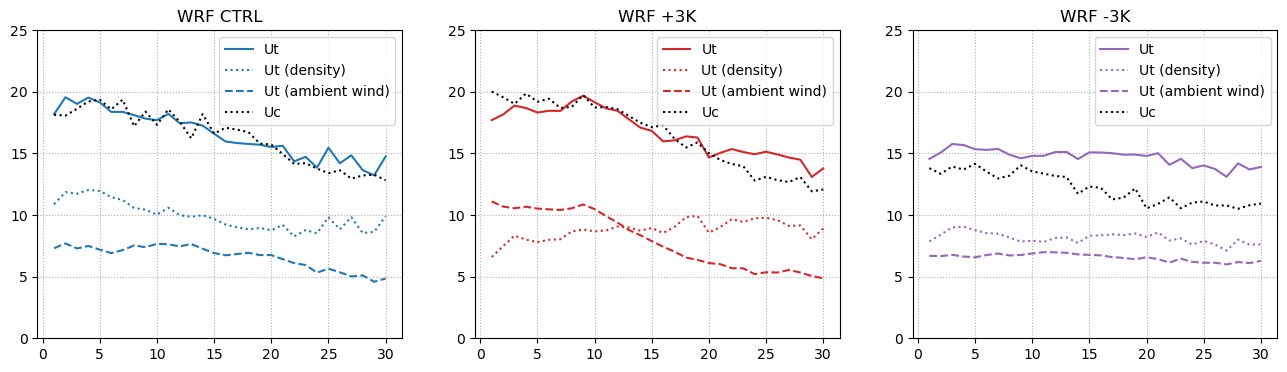

In [11]:
plt.figure(figsize=[16,4])
for t,ls,c,title in zip([0,1,2],[ctrl_list,plus_3K_list,minus_3K_list],["tab:blue","tab:red","tab:purple"],["WRF CTRL","WRF +3K","WRF -3K"]):
    plt.subplot(1,3,t+1)
    plt.plot(range(1,31),theory(ls)[0].mean("Time"),color=c,ls="-",label="Ut")
    plt.plot(range(1,31),theory(ls)[1].mean("Time"),color=c,ls=":",label="Ut (density)")
    plt.plot(range(1,31),theory(ls)[2].mean("Time"),color=c,ls="--",label="Ut (ambient wind)")
    plt.plot(range(1,31),ls.Uc.mean("Time"),color="k",ls=":",label="Uc")
    plt.ylim([0,25])
    plt.gca().grid(ls=":") 
    plt.title(title)
    plt.legend() 

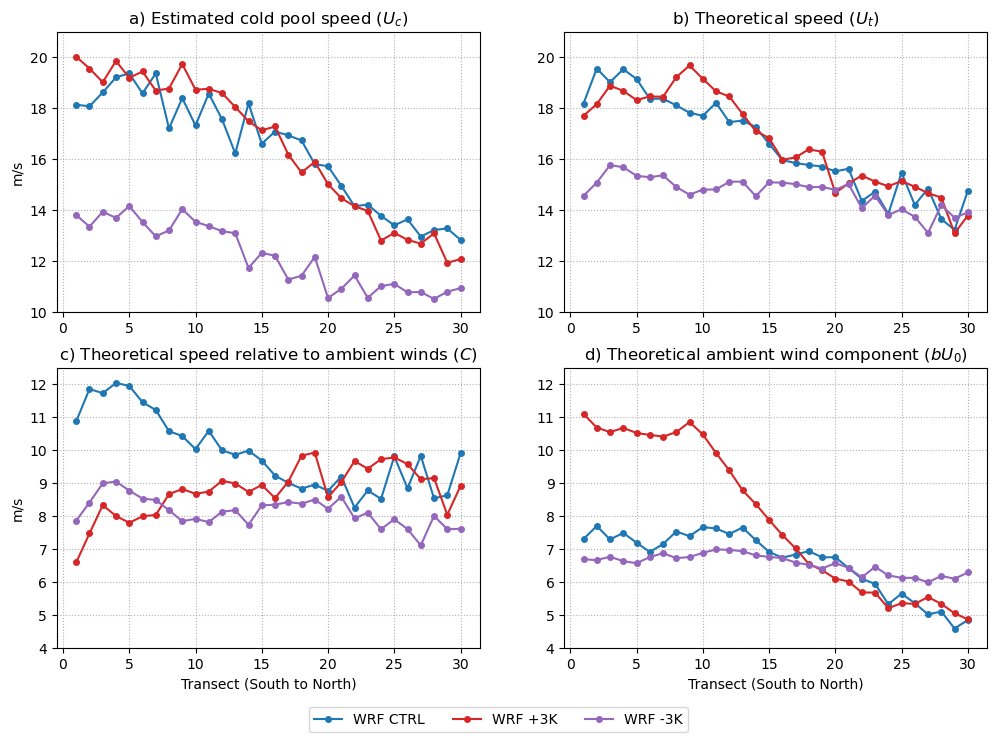

In [54]:
fig=plt.figure(figsize=[12,8])
plt.subplot(2,2,2)
plt.plot(range(1,31),theory(ctrl_list)[0].mean("Time"),color="tab:blue",ls="-",marker="o",ms=4)
plt.plot(range(1,31),theory(plus_3K_list)[0].mean("Time"),color="tab:red",ls="-",marker="o",ms=4)
plt.plot(range(1,31),theory(minus_3K_list)[0].mean("Time"),color="tab:purple",ls="-",marker="o",ms=4)
plt.ylim([10,21])
plt.gca().grid(ls=":")
plt.title("b) Theoretical speed ($U_t$)")

plt.subplot(2,2,1)
plt.plot(range(1,31),ctrl_list.Uc.mean("Time"),color="tab:blue",ls="-",marker="o",ms=4)
plt.plot(range(1,31),plus_3K_list.Uc.mean("Time"),color="tab:red",ls="-",marker="o",ms=4)
plt.plot(range(1,31),minus_3K_list.Uc.mean("Time"),color="tab:purple",ls="-",marker="o",ms=4)
plt.ylim([10,21])
plt.gca().grid(ls=":")
plt.title("a) Estimated cold pool speed ($U_c$)")
plt.ylabel("m/s")

plt.subplot(2,2,3)
plt.plot(range(1,31),theory(ctrl_list)[1].mean("Time"),color="tab:blue",ls="-",marker="o",ms=4,label="WRF CTRL")
plt.plot(range(1,31),theory(plus_3K_list)[1].mean("Time"),color="tab:red",ls="-",marker="o",ms=4,label="WRF +3K")
plt.plot(range(1,31),theory(minus_3K_list)[1].mean("Time"),color="tab:purple",ls="-",marker="o",ms=4,label="WRF -3K")
plt.ylim([4,12.5])
plt.gca().grid(ls=":")
plt.title("c) Theoretical speed relative to ambient winds ($C$)")
plt.xlabel("Transect (South to North)")
plt.ylabel("m/s")
fig.legend(loc="lower center",ncol=3)

plt.subplot(2,2,4)
plt.plot(range(1,31),theory(ctrl_list)[2].mean("Time"),color="tab:blue",ls="-",label="Ut",marker="o",ms=4)
plt.plot(range(1,31),theory(plus_3K_list)[2].mean("Time"),color="tab:red",ls="-",label="Ut",marker="o",ms=4)
plt.plot(range(1,31),theory(minus_3K_list)[2].mean("Time"),color="tab:purple",ls="-",label="Ut",marker="o",ms=4)
plt.ylim([4,12.5])
plt.gca().grid(ls=":")
plt.title("d) Theoretical ambient wind component ($bU_0$)")
plt.xlabel("Transect (South to North)")
plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/cold_pool_speed.jpeg",dpi=400,bbox_inches="tight")

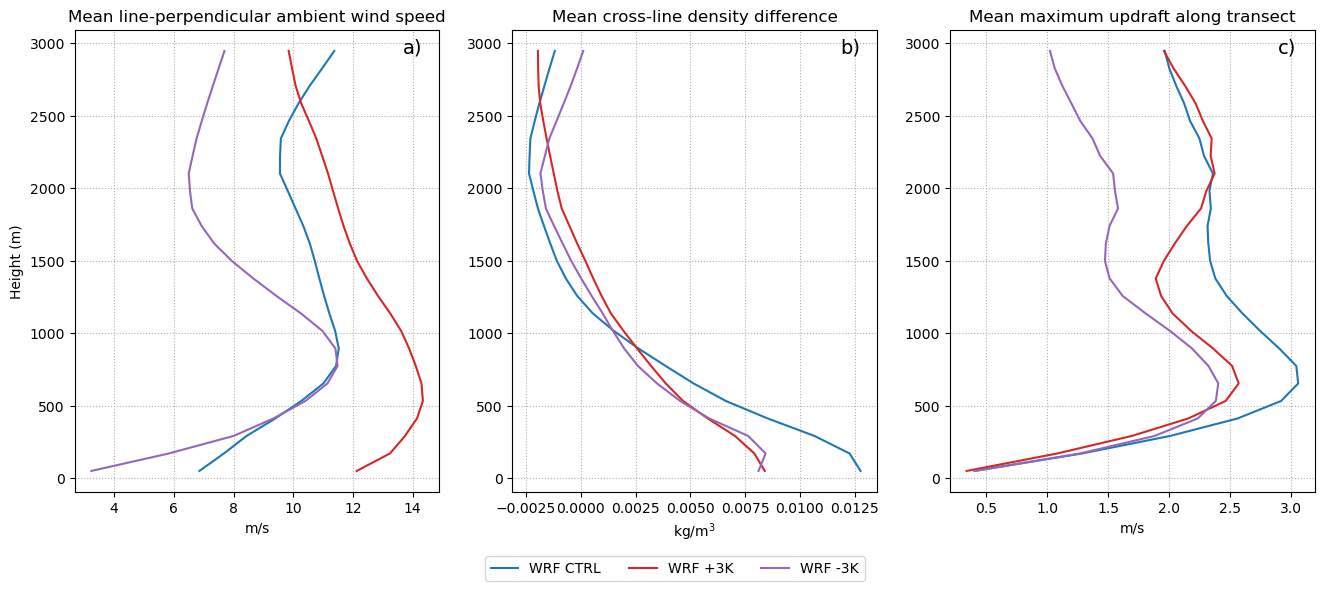

In [51]:
fig=plt.figure(figsize=[16,6])
ax=plt.subplot(1,3,1)
ctrl_list.along_transect_wind.sel(vertical=slice(0,3000),cross_line_idx=slice(25,50),transect=slice(0,14)).mean(("Time","cross_line_idx","transect")).plot(color="tab:blue",y="vertical")
plus_3K_list.along_transect_wind.sel(vertical=slice(0,3000),cross_line_idx=slice(25,50),transect=slice(0,14)).mean(("Time","cross_line_idx","transect")).plot(color="tab:red",y="vertical")
minus_3K_list.along_transect_wind.sel(vertical=slice(0,3000),cross_line_idx=slice(25,50),transect=slice(0,14)).mean(("Time","cross_line_idx","transect")).plot(color="tab:purple",y="vertical")
ax.grid(ls=":")
ax.set_xlabel("m/s")
ax.set_title("Mean line-perpendicular ambient wind speed")
ax.set_ylabel("Height (m)")
ax.text(0.9,0.95,"a)",size=14,transform=ax.transAxes)

ax=plt.subplot(1,3,2)
l1=(ctrl_list.rho.sel(cross_line_idx=slice(20,25),transect=slice(0,14)).mean("cross_line_idx")
    - ctrl_list.rho.sel(cross_line_idx=slice(25,30),transect=slice(0,14)).mean("cross_line_idx")).sel(vertical=slice(0,3000)).mean(("Time","transect")).plot(color="tab:blue",y="vertical")
l2=(plus_3K_list.rho.sel(cross_line_idx=slice(20,25),transect=slice(0,14)).mean("cross_line_idx")
    - plus_3K_list.rho.sel(cross_line_idx=slice(25,30),transect=slice(0,14)).mean("cross_line_idx")).sel(vertical=slice(0,3000)).mean(("Time","transect")).plot(color="tab:red",y="vertical")
l3=(minus_3K_list.rho.sel(cross_line_idx=slice(20,25),transect=slice(0,14)).mean("cross_line_idx")
    - minus_3K_list.rho.sel(cross_line_idx=slice(25,30),transect=slice(0,14)).mean("cross_line_idx")).sel(vertical=slice(0,3000)).mean(("Time","transect")).plot(color="tab:purple",y="vertical")
ax.grid(ls=":")
ax.set_xlabel("kg/m$^3$")
ax.set_title("Mean cross-line density difference")
ax.set_ylabel("")
ax.text(0.9,0.95,"b)",size=14,transform=ax.transAxes)

ax=plt.subplot(1,3,3)
ctrl_list.w.sel(vertical=slice(0,3000)).max("cross_line_idx").mean(("Time","transect")).plot(color="tab:blue",y="vertical",label="WRF CTRL")
plus_3K_list.w.sel(vertical=slice(0,3000)).max("cross_line_idx").mean(("Time","transect")).plot(color="tab:red",y="vertical",label="WRF +3K")
minus_3K_list.w.sel(vertical=slice(0,3000)).max("cross_line_idx").mean(("Time","transect")).plot(color="tab:purple",y="vertical",label="WRF -3K")

ax.grid(ls=":")
ax.set_xlabel("m/s")
ax.set_title("Mean maximum updraft along transect")
ax.set_ylabel("")
ax.text(0.9,0.95,"c)",size=14,transform=ax.transAxes)

fig.legend(loc="lower center",ncol=3,bbox_to_anchor=(0.5,-0.05))
plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/compare_profiles.jpeg",dpi=400,bbox_inches="tight")